# FINM 359000 Macro Finance
## Problem Set 2
### Group Members:
- Hongsen (Henry) Fu
- Huayu (Alaia) Zhu
- Mange (Kevin) He
- Yuxuan (Ryan) Bai

# Import Necessary Libraries

In [114]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import datetime
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import kpss, adfuller
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import statsmodels.api as sm

# Macro Regimes

## 4. Choose two different 1 macro variable data series you can get monthly data on that you think matter for macro asset prices. Choose series that have data available since at least 1995 (you may look back further and will learn more in what follows if you do). Why do you think they matter for macro asset prices, and how? (Be explicit, e.g., “when X happens to variable Y, I would expect asset price Z to go in direction Q”.)

In [126]:
# Get SPX data
ticker_symbol = "^GSPC"
data = yf.Ticker(ticker_symbol)

# Retrieve monthly data
spx_data = data.history(period="max", start="1995-01-01", end="2024-05-01", interval="1mo")[['Close']]
spx_data.index = pd.to_datetime(spx_data.index).date

# Print the first few rows of the DataFrame
print(spx_data.head())

                 Close
1995-01-01  470.420013
1995-02-01  487.390015
1995-03-01  500.709991
1995-04-01  514.710022
1995-05-01  533.400024


In [127]:
# extract CAPE ratio from the website
from bs4 import BeautifulSoup
url = "https://www.multpl.com/shiller-pe/table/by-month"
response = requests.get(url)
response.raise_for_status() 
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table')
cape_ratio = pd.read_html(str(table))[0]  
cape_ratio = cape_ratio.set_index('Date')
cape_ratio.index = pd.to_datetime(cape_ratio.index, format='%b %d, %Y')  
cape_ratio = cape_ratio.loc['1995-01-01':]
print(cape_ratio.head())

            Value
Date             
2024-05-08  33.95
2024-05-01  33.18
2024-04-01  33.49
2024-03-01  33.91
2024-02-01  33.11


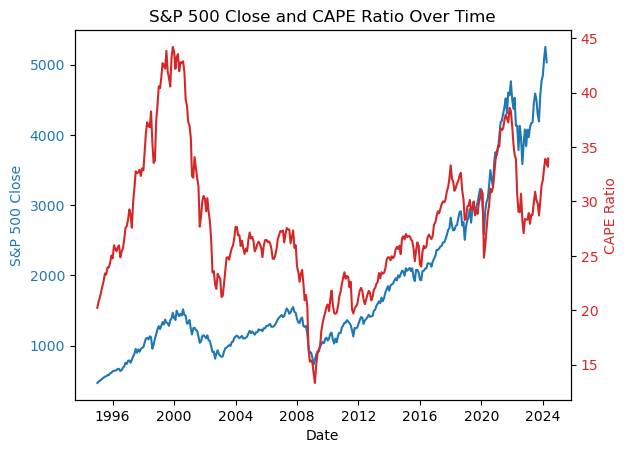

In [128]:
# Create a new figure and an axes object for the plot
fig, ax1 = plt.subplots()

# Plot the S&P 500 data on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Close', color=color)
ax1.plot(spx_data.index, spx_data['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second axes object for the CAPE ratio using the same x-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('CAPE Ratio', color=color)  # we already handled the x-label with ax1
ax2.plot(cape_ratio.index, cape_ratio['Value'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('S&P 500 Close and CAPE Ratio Over Time')
plt.show()

In [132]:
# perform OLS
data = pd.merge(spx_data, cape_ratio, left_index=True, right_index=True, how='inner')
data.columns = ['SPX_Close', 'CAPE_Ratio']

X = data[['CAPE_Ratio']]  # Predictor
y = data['SPX_Close']     # Response

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SPX_Close   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     50.31
Date:                Wed, 08 May 2024   Prob (F-statistic):           7.31e-12
Time:                        19:05:33   Log-Likelihood:                -2943.1
No. Observations:                 352   AIC:                             5890.
Df Residuals:                     350   BIC:                             5898.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.4275    259.830      0.109      0.9

When the CAPE ratio rises significantly above its historical average, indicating that stocks are overvalued relative to their earnings over the past decade, I would expect the asset prices of major stock indices like the S&P 500 to eventually decline. This expectation stems from the tendency of markets to correct overvaluations as investors reassess the sustainability of high stock prices without corresponding growth in earnings, leading to a reversion to more typical valuation levels. Such an adjustment typically results in reduced investor enthusiasm and a subsequent drop in asset prices.